In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

# --- 1. Load the Dataset using ucimlrepo ---
print("Fetching dataset from UCI Machine Learning Repository...")
try:
    # fetch dataset
    online_retail = fetch_ucirepo(id=352)

    # data (as pandas dataframes)
    # FIX: Use .original to get all columns including 'ID' columns like InvoiceNo and StockCode
    df = online_retail.data.original
    print("Dataset loaded successfully from UCI!")

except Exception as e:
    print(f"Error fetching dataset from UCI: {e}")
    print("Please ensure you have 'ucimlrepo' installed (pip install ucimlrepo) and an active internet connection.")
    exit() # Exiting if we can't load the data

print("\n--- Initial Glance (First 5 Rows) ---")
print(df.head())

print("\n--- Dataset Information Before Cleaning ---")
print(df.info())

print("\n--- Descriptive Statistics for Numerical Columns Before Cleaning ---")
print(df.describe())

Fetching dataset from UCI Machine Learning Repository...
Dataset loaded successfully from UCI!

--- Initial Glance (First 5 Rows) ---
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

--- Dataset Information Before Cleaning ---
<class 'pandas.core.frame.DataFram

In [ ]:
# --- 3. Handle Missing Values ---
print("\n--- Missing Values Before Handling ---")
print(df.isnull().sum())

# Handling CustomerID missing values:
# For this project focusing on sales/demand/price, CustomerID missing won't impact core calculations
# like total sales or product sales directly. However, it's good practice to handle it.
# Let's fill CustomerID NaNs with 0, indicating 'Guest' or unknown customer.
# This prevents errors in operations that might expect a non-null value if we were to use it.
df['CustomerID'] = df['CustomerID'].fillna(0)
print("\n'CustomerID' NaN values filled with 0.")

# --- 4. Handle Cancellations and Non-Positive Quantities/Prices ---
# Invoices starting with 'C' indicate cancellations. These often have negative quantities.
# For sales and demand forecasting, we will remove these to focus on valid, positive sales.
df_original_rows = len(df)

# First, filter out rows where 'InvoiceNo' starts with 'C'
# Ensure 'InvoiceNo' is treated as string for the 'contains' method, handling potential non-string types
df = df[~df['InvoiceNo'].astype(str).str.contains('C', na=False)]
print(f"\nRemoved {df_original_rows - len(df)} rows corresponding to cancelled orders (InvoiceNo starting with 'C').")

# Next, remove rows where Quantity is non-positive (returns not explicitly marked with 'C' or other errors)
df_current_rows_after_cancel_filter = len(df)
df = df[df['Quantity'] > 0]
print(f"Removed {df_current_rows_after_cancel_filter - len(df)} rows with non-positive Quantity (after removing cancellations).")

# Also, remove rows where UnitPrice is non-positive (errors or zero-value items)
df_current_rows_after_qty_filter = len(df)
df = df[df['UnitPrice'] > 0]
print(f"Removed {df_current_rows_after_qty_filter - len(df)} rows with non-positive UnitPrice.")
print(f"Remaining rows after cleaning: {len(df)}")


# --- 5. Basic Feature Engineering ---

# Convert InvoiceDate to datetime objects
# Based on your sample '12/1/2010 8:26', the format is '%m/%d/%Y %H:%M'
# Ensure 'InvoiceDate' column is clean before conversion; 'errors=coerce' will turn unparseable dates into NaT
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M', errors='coerce')
# Drop rows where InvoiceDate could not be parsed
df.dropna(subset=['InvoiceDate'], inplace=True)
print("\n'InvoiceDate' column converted to datetime.")


# Create a 'Sales' (or LineTotal) column
# Ensure UnitPrice is numeric before multiplication (already handled by df['UnitPrice'] > 0 check)
df['Sales'] = df['Quantity'] * df['UnitPrice']
print("\n'Sales' (LineTotal) column created.")

# Quick check for NaNs after creating 'Sales' (should be minimal after previous filters)
if df['Sales'].isnull().any():
    print("Warning: NaN values found in 'Sales' column after creation. This might indicate issues after initial cleaning.")
    df.dropna(subset=['Sales'], inplace=True) # Drop rows where Sales could not be calculated
    print(f"Removed rows with NaN in 'Sales' column. Remaining rows: {len(df)}")


print("\n--- Initial Data Preparation Complete! ---")
print("\n--- Final DataFrame Info After Cleaning ---")
print(df.info())
print("\n--- Final DataFrame Head After Cleaning ---")
print(df.head())
print("\n--- Final DataFrame Describe After Cleaning ---")
print(df.describe())


--- Missing Values Before Handling ---
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

'CustomerID' NaN values filled with 0.

Removed 9288 rows corresponding to cancelled orders (InvoiceNo starting with 'C').
Removed 1336 rows with non-positive Quantity (after removing cancellations).
Removed 1181 rows with non-positive UnitPrice.
Remaining rows after cleaning: 530104

'InvoiceDate' column converted to datetime.

'Sales' (LineTotal) column created.

--- Initial Data Preparation Complete! ---

--- Final DataFrame Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Desc


--- Preparing Data for Sales Trend Forecasting ---

Daily Sales Aggregation Head:
               Sales
InvoiceDay          
2010-12-01  58960.79
2010-12-02  47748.38
2010-12-03  46943.71
2010-12-05  31774.95
2010-12-06  54830.46

Daily Sales Aggregation Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2010-12-01 to 2011-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   305 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB
None

Resampled Daily Sales (first 5 rows with potential filled values):
               Sales
2010-12-01  58960.79
2010-12-02  47748.38
2010-12-03  46943.71
2010-12-04      0.00
2010-12-05  31774.95

Resampled Daily Sales (last 5 rows with potential filled values):
                Sales
2011-12-05   88741.96
2011-12-06   56713.21
2011-12-07   75439.16
2011-12-08   82495.00
2011-12-09  200920.60
Total days in dataset (after resampling): 374

--- Visualizing Dail

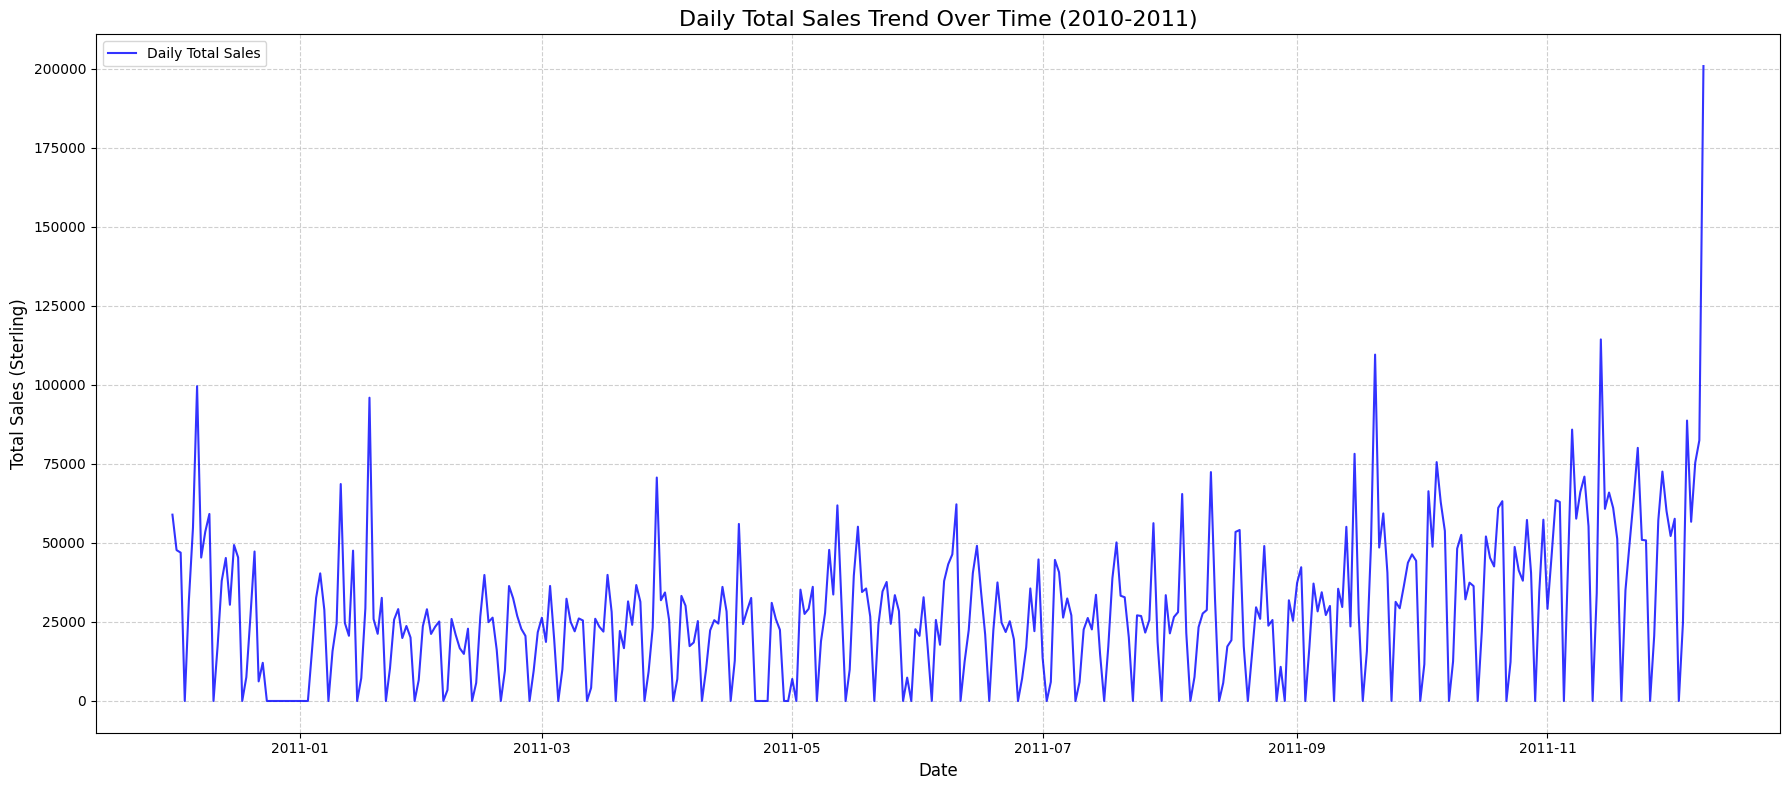

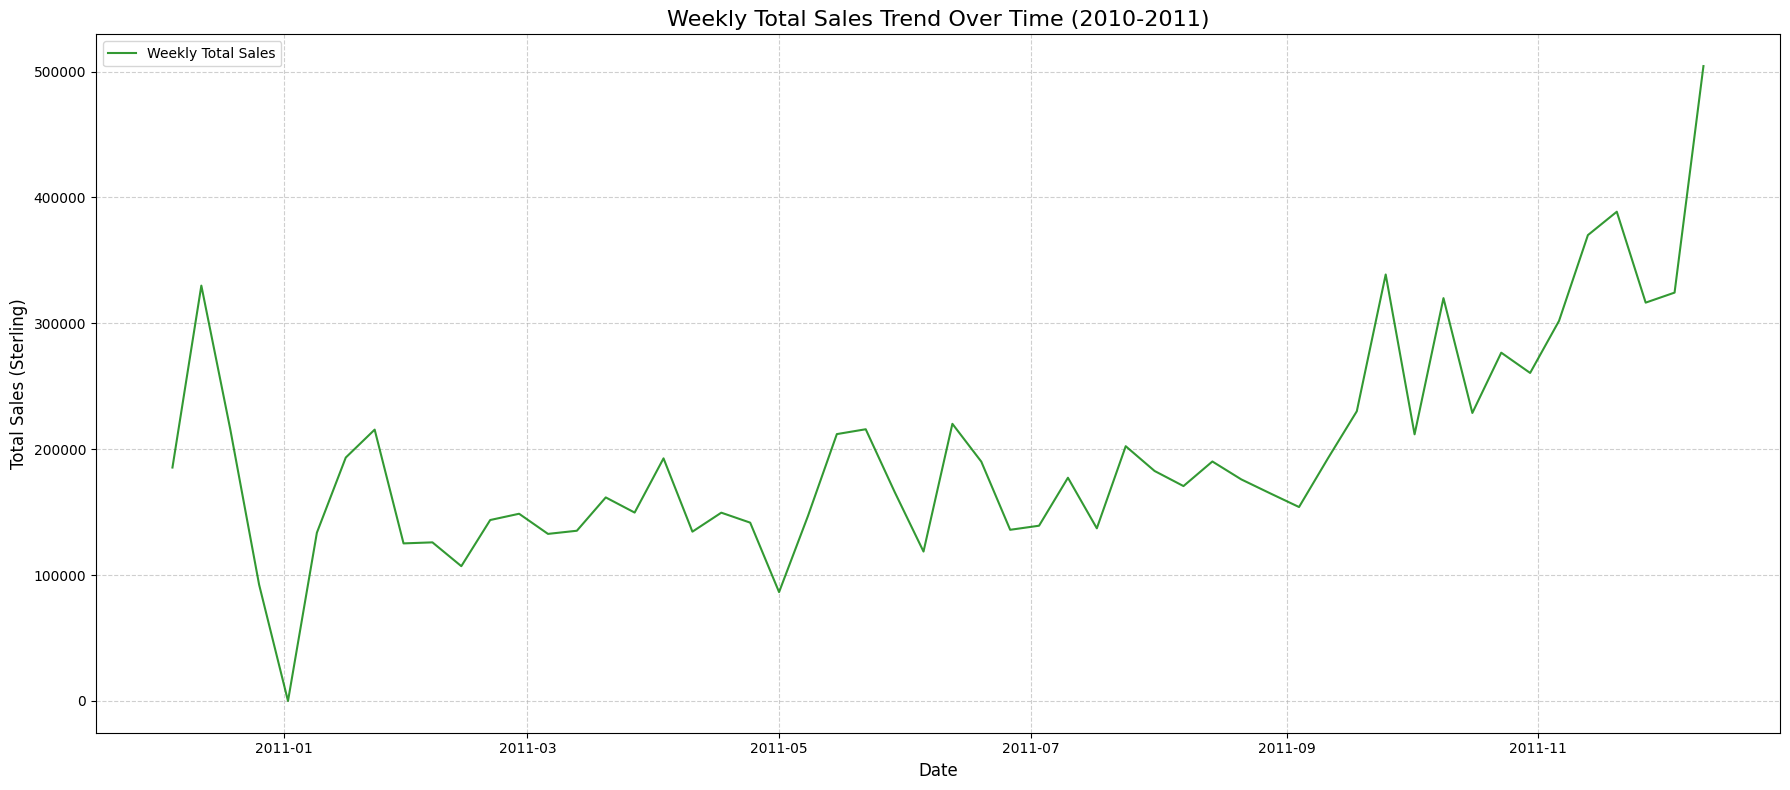


--- Sales Data Aggregated and Visualized. Ready for Forecasting Models! ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your prepared DataFrame from the previous cleaning steps

print("\n--- Preparing Data for Sales Trend Forecasting ---")

# 1. Aggregate Daily Sales
# Extract the date part from InvoiceDate
# .dt.date gives a datetime.date object, which is good for grouping,
# but we'll convert back to datetime64[ns] for the index later.
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Group by InvoiceDay and sum the Sales to get daily total sales
daily_sales = df.groupby('InvoiceDay')['Sales'].sum().reset_index()

# Convert InvoiceDay back to datetime for proper time series indexing
daily_sales['InvoiceDay'] = pd.to_datetime(daily_sales['InvoiceDay'])

# Set InvoiceDay as the index for time series operations
daily_sales.set_index('InvoiceDay', inplace=True)

print("\nDaily Sales Aggregation Head:")
print(daily_sales.head())
print("\nDaily Sales Aggregation Info:")
print(daily_sales.info())


# 2. Handle Missing Dates (Resampling)
# Create a full date range from the min to max date in your data
# This ensures every day is present, even if there were no sales.
full_date_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')

# Reindex the daily_sales DataFrame to include all dates in the range
# Fill missing dates (days with no sales) with 0
daily_sales = daily_sales.reindex(full_date_range, fill_value=0)

print(f"\nResampled Daily Sales (first 5 rows with potential filled values):")
print(daily_sales.head())
print(f"\nResampled Daily Sales (last 5 rows with potential filled values):")
print(daily_sales.tail())
print(f"Total days in dataset (after resampling): {len(daily_sales)}")


# 3. Visualize the Daily Sales Trend
print("\n--- Visualizing Daily Sales Trend ---")

plt.figure(figsize=(18, 8)) # Increased figure size for better readability
plt.plot(daily_sales.index, daily_sales['Sales'], label='Daily Total Sales', color='blue', alpha=0.8)
plt.title('Daily Total Sales Trend Over Time (2010-2011)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (Sterling)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Plotting weekly or monthly sales for clearer trends
# Resample to weekly sales (sum sales over a week)
weekly_sales = daily_sales['Sales'].resample('W').sum()
plt.figure(figsize=(18, 8)) # Increased figure size
plt.plot(weekly_sales.index, weekly_sales, label='Weekly Total Sales', color='green', alpha=0.8)
plt.title('Weekly Total Sales Trend Over Time (2010-2011)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (Sterling)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


print("\n--- Sales Data Aggregated and Visualized. Ready for Forecasting Models! ---")


--- Applying Prophet Model for Sales Trend Forecasting ---

Prophet Dataframe Head:
                   ds         y
2010-12-01 2010-12-01  58960.79
2010-12-02 2010-12-02  47748.38
2010-12-03 2010-12-03  46943.71
2010-12-04 2010-12-04      0.00
2010-12-05 2010-12-05  31774.95

Prophet Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374 entries, 2010-12-01 to 2011-12-09
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      374 non-null    datetime64[ns]
 1   y       374 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.8 KB
None


DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/r0h5hqu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/je8j9nx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2474', 'data', 'file=/tmp/tmppdjrv7jf/r0h5hqu9.json', 'init=/tmp/tmppdjrv7jf/je8j9nx4.json', 'output', 'file=/tmp/tmppdjrv7jf/prophet_modeltomlg5pt/prophet_model-20250613161513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Prophet model fitted successfully.

Forecast Head (first 5 rows of future predictions):
          ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  41772.561300  20819.901092  58214.721894
1 2010-12-02  49679.450608  29684.806471  67004.735483
2 2010-12-03  44204.344694  26398.632011  62671.667811
3 2010-12-04  11938.235881  -6223.106218  29887.110438
4 2010-12-05  28124.724762   8894.602269  45816.601207

Forecast Tail (last 5 rows of future predictions):
            ds          yhat    yhat_lower    yhat_upper
399 2012-01-04  42537.470875  23127.818428  60840.441661
400 2012-01-05  50319.682018  32702.147990  69712.679410
401 2012-01-06  45068.445876  26714.455951  62603.921083
402 2012-01-07  13369.985699  -5809.048188  31661.607409
403 2012-01-08  30456.737318  12255.983189  48931.688278

--- Visualizing Sales Forecast ---


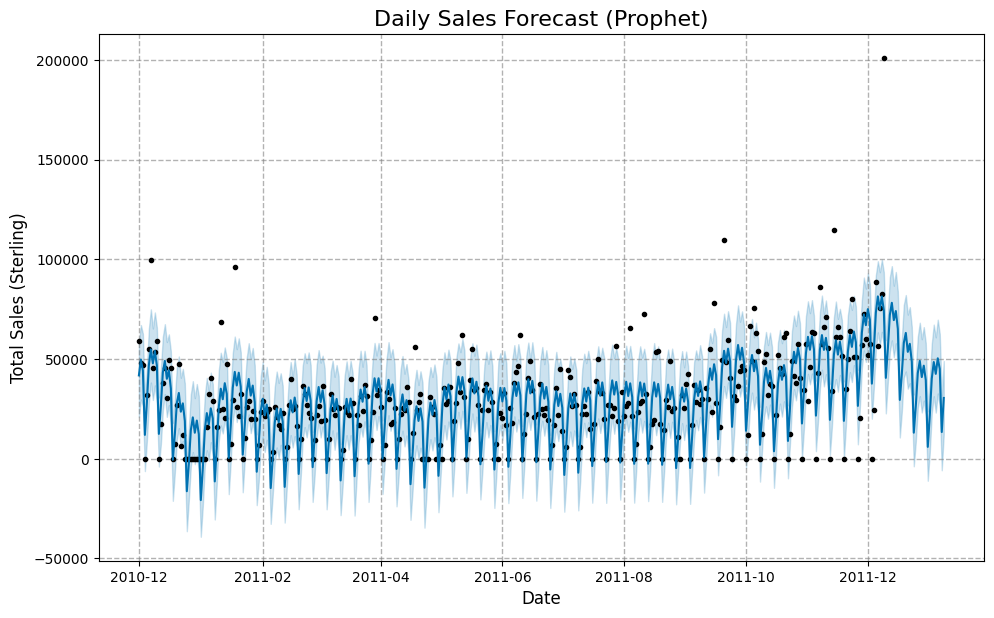

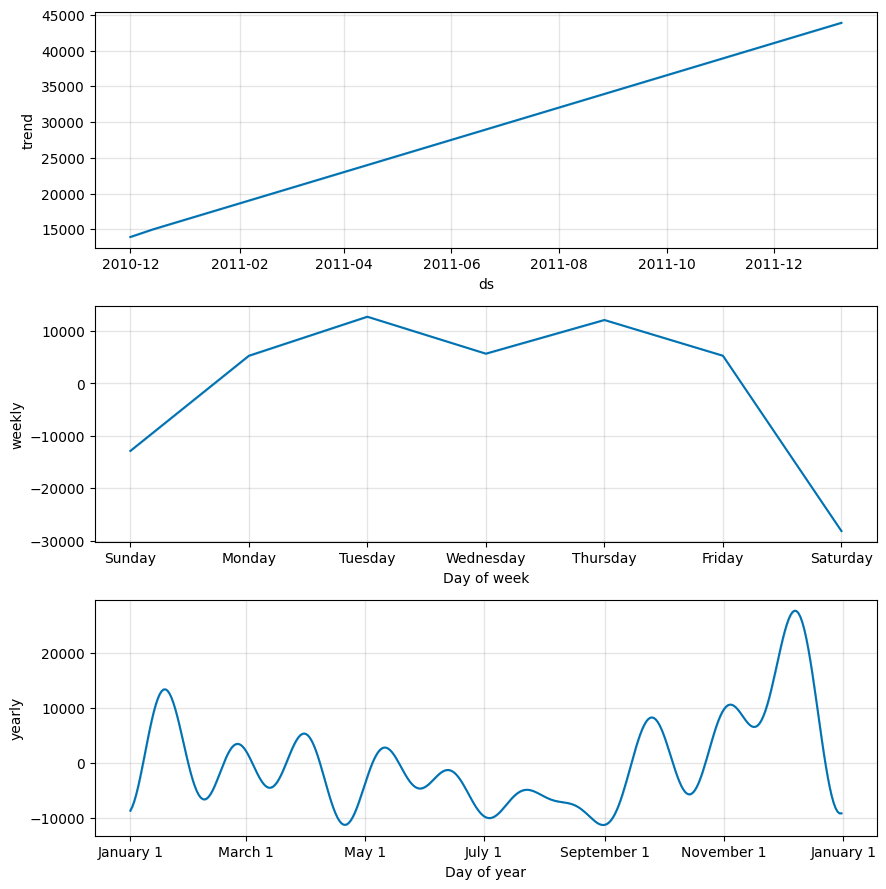


--- Sales Trend Forecasting Complete! ---


In [ ]:
from prophet import Prophet

# Assuming 'daily_sales' DataFrame is prepared from the previous step

print("\n--- Applying Prophet Model for Sales Trend Forecasting ---")

# 1. Prepare Data for Prophet
# Prophet requires columns to be named 'ds' (datetime) and 'y' (value)
# Explicitly create the DataFrame to avoid issues with index naming
prophet_df = pd.DataFrame({
    'ds': daily_sales.index,   # Assign the DataFrame's index (which are the dates) to 'ds'
    'y': daily_sales['Sales']  # Assign the 'Sales' column to 'y'
})

# Ensure 'ds' is datetime type (it already should be from the index, but good to confirm)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

print("\nProphet Dataframe Head:")
print(prophet_df.head())
print("\nProphet Dataframe Info:")
print(prophet_df.info())


# 2. Initialize and Fit the Prophet Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.fit(prophet_df)
print("\nProphet model fitted successfully.")


# 3. Make Future Predictions
# Create a DataFrame with future dates for forecasting
# Let's forecast for the next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

print("\nForecast Head (first 5 rows of future predictions):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print("\nForecast Tail (last 5 rows of future predictions):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


# 4. Visualize the Forecast
print("\n--- Visualizing Sales Forecast ---")

fig1 = model.plot(forecast)
plt.title('Daily Sales Forecast (Prophet)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (Sterling)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Visualize forecast components (trend, weekly, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

print("\n--- Sales Trend Forecasting Complete! ---")


--- Starting Demand Forecasting (Product Level) ---

Selected products for detailed demand forecasting (based on sales frequency and quantity): ['23166', '22197', '84077']

--- Processing product: 23166 ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/uwy6_0g0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/4ytyz0u1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43806', 'data', 'file=/tmp/tmppdjrv7jf/uwy6_0g0.json', 'init=/tmp/tmppdjrv7jf/4ytyz0u1.json', 'output', 'file=/tmp/tmppdjrv7jf/prophet_modelcdzz2nbf/prophet_model-20250613161626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Total days in dataset for 23166 (after resampling): 326
Prophet model fitted for product 23166.
Forecast Head for 23166 (future predictions):
            ds          yhat    yhat_lower    yhat_upper
351 2012-01-04  -1414.534672  -5996.134039   3008.574386
352 2012-01-05  -5286.627308  -9541.811372   -687.643754
353 2012-01-06  -9428.069731 -13646.682932  -5119.735570
354 2012-01-07 -13714.206998 -18005.286251  -9459.009355
355 2012-01-08 -18239.892851 -22544.156761 -13686.361524


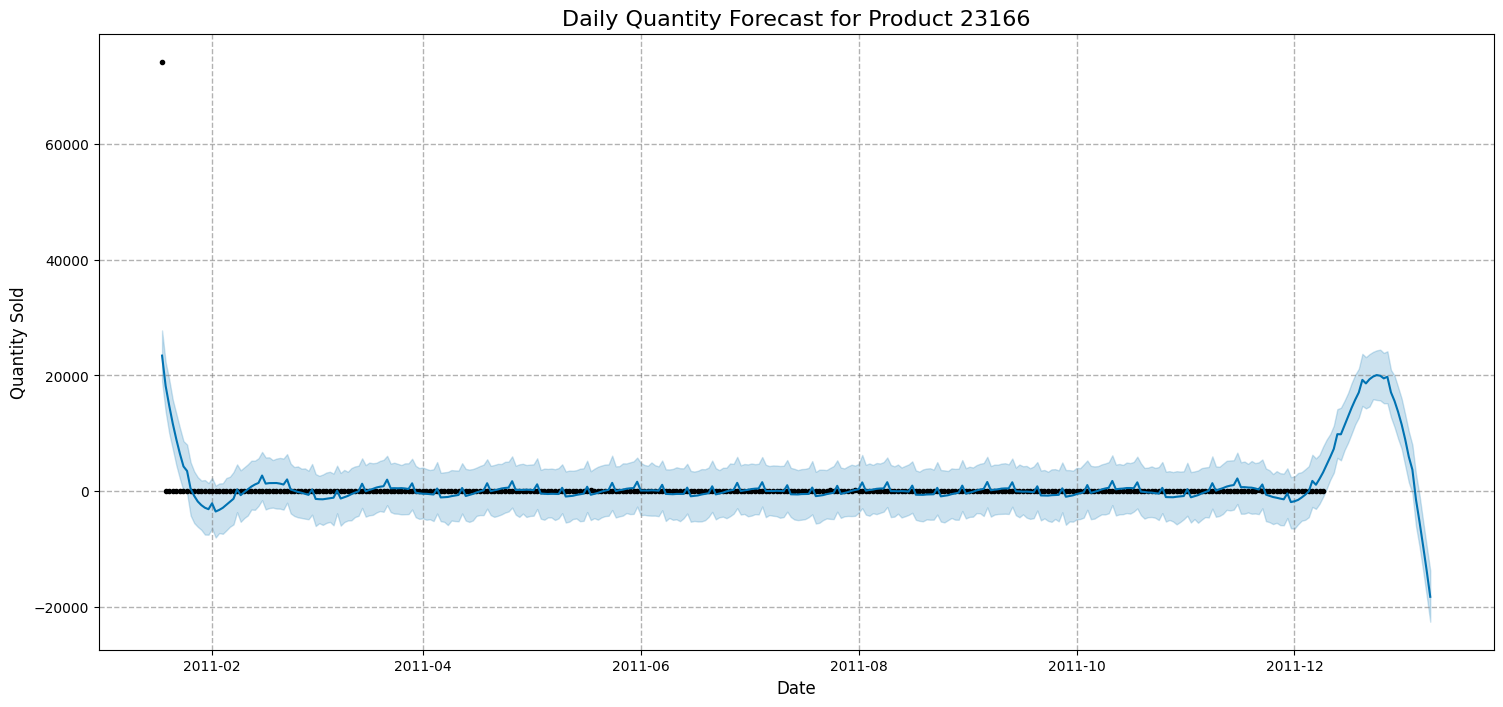

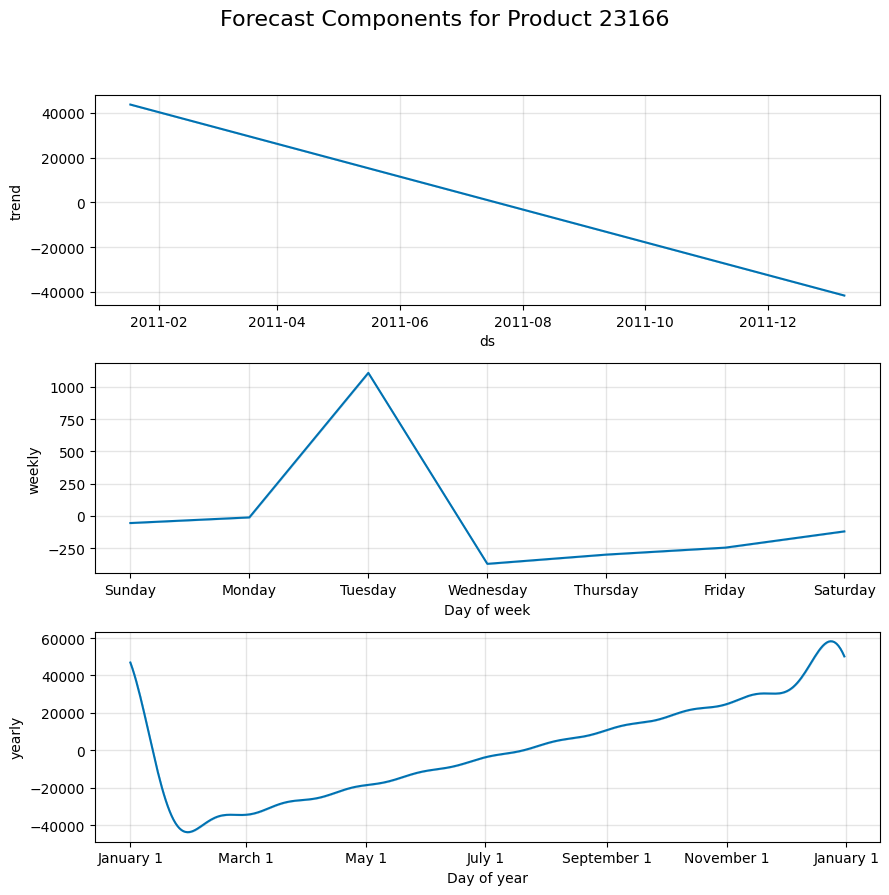

DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/lejeyrse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/vqb1t2y8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5241', 'data', 'file=/tmp/tmppdjrv7jf/lejeyrse.json', 'init=/tmp/tmppdjrv7jf/vqb1t2y8.json', 'output', 'file=/tmp/tmppdjrv7jf/prophet_modelswzf5saj/prophet_model-20250613161627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Processing product: 22197 ---
Total days in dataset for 22197 (after resampling): 374
Prophet model fitted for product 22197.
Forecast Head for 22197 (future predictions):
            ds        yhat  yhat_lower   yhat_upper
399 2012-01-04  600.958631  157.852486  1022.065898
400 2012-01-05  670.467795  208.904206  1089.115019
401 2012-01-06  737.080944  274.284455  1183.473017
402 2012-01-07  446.908070    1.774601   882.018540
403 2012-01-08  499.770822   62.893961   908.385776


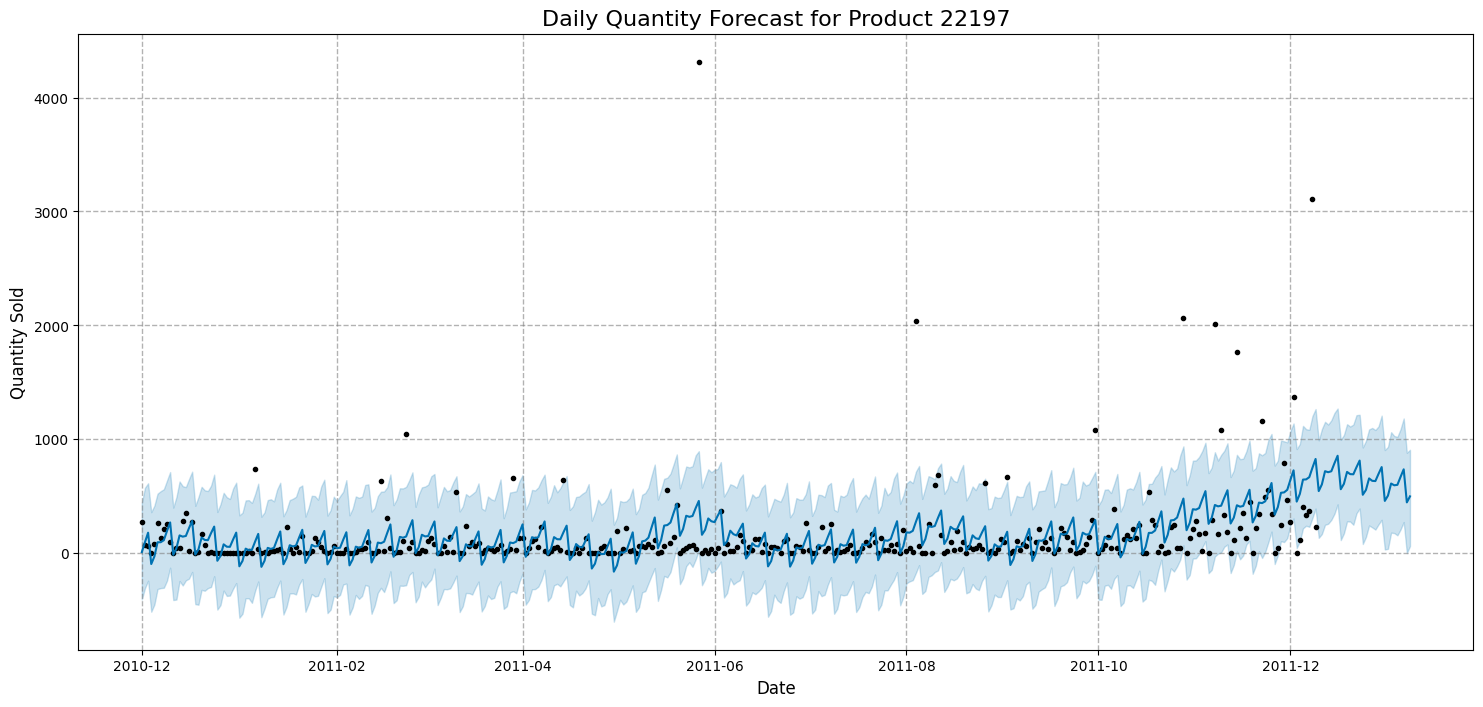

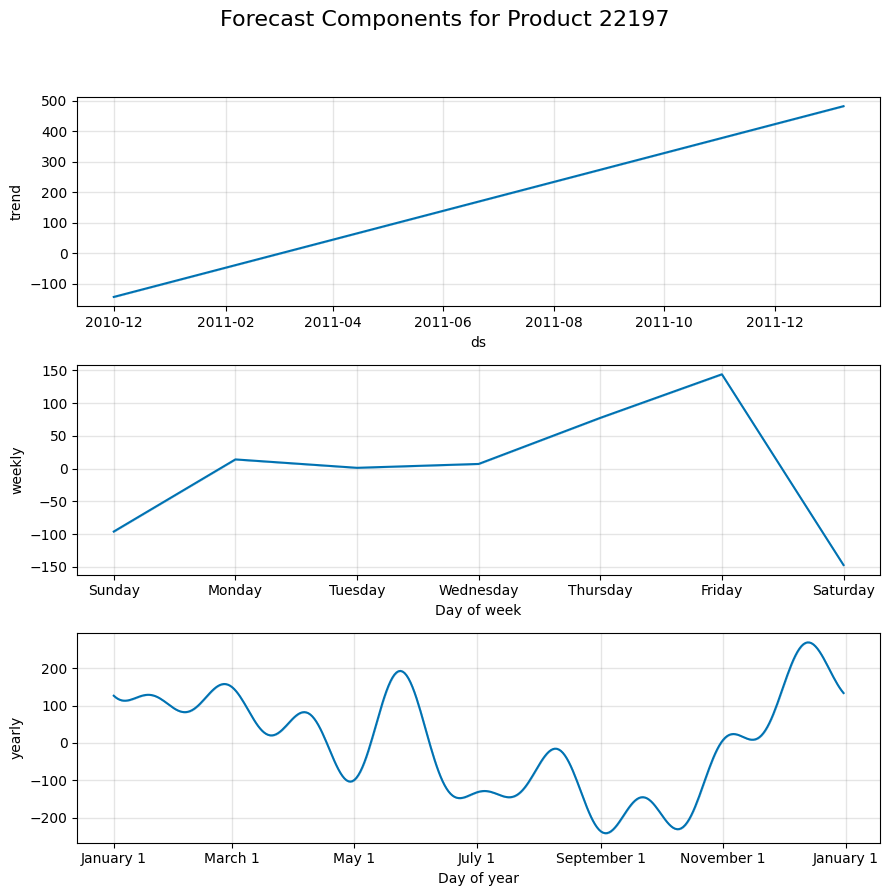

DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/5n5f9g2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppdjrv7jf/qvdc2h7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74587', 'data', 'file=/tmp/tmppdjrv7jf/5n5f9g2j.json', 'init=/tmp/tmppdjrv7jf/qvdc2h7s.json', 'output', 'file=/tmp/tmppdjrv7jf/prophet_modelhiegz4j6/prophet_model-20250613161628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



--- Processing product: 84077 ---
Total days in dataset for 84077 (after resampling): 373
Prophet model fitted for product 84077.
Forecast Head for 84077 (future predictions):
            ds        yhat   yhat_lower  yhat_upper
398 2012-01-04 -392.288514  -878.502452  115.101831
399 2012-01-05 -247.972103  -707.592153  264.894360
400 2012-01-06 -417.418435  -876.184962   38.457159
401 2012-01-07 -569.282069 -1024.282062  -58.549434
402 2012-01-08 -489.703801  -957.303194    2.406508


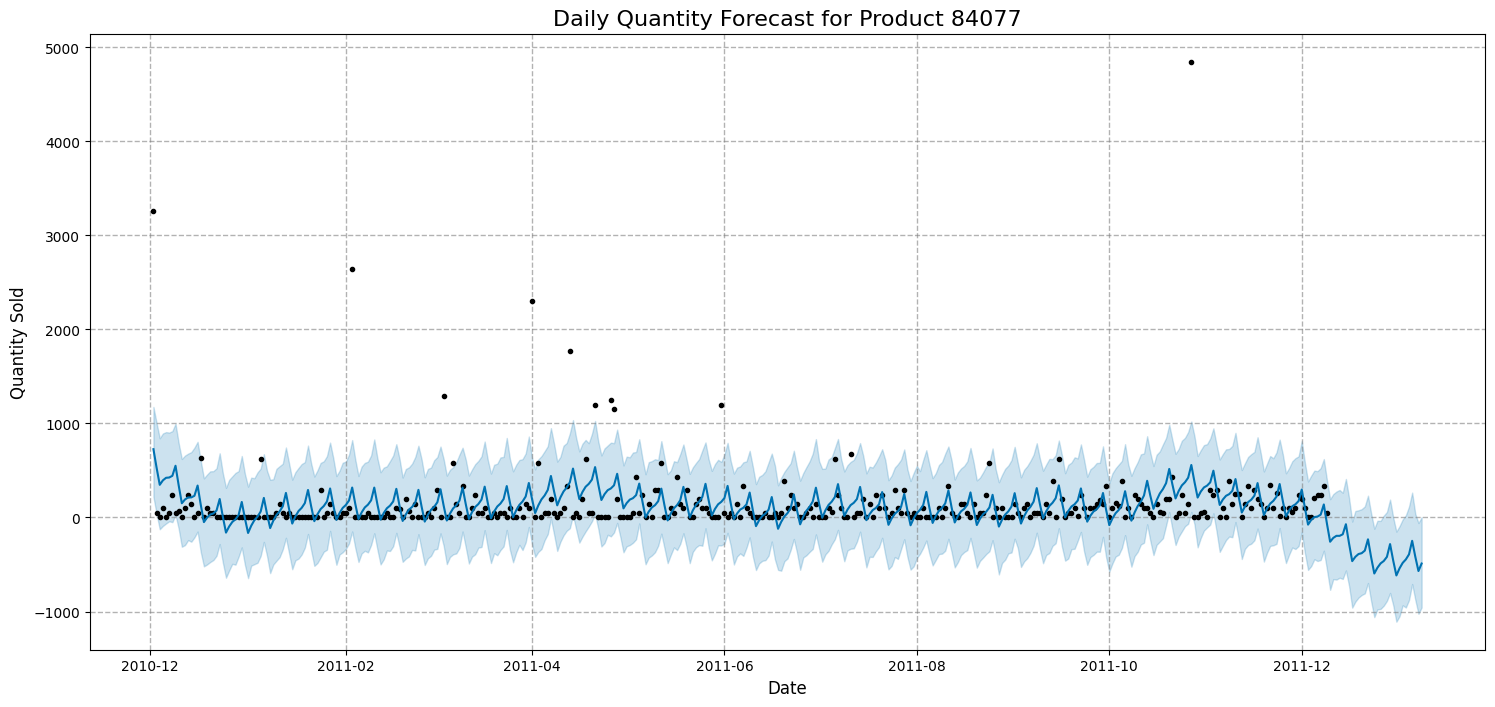

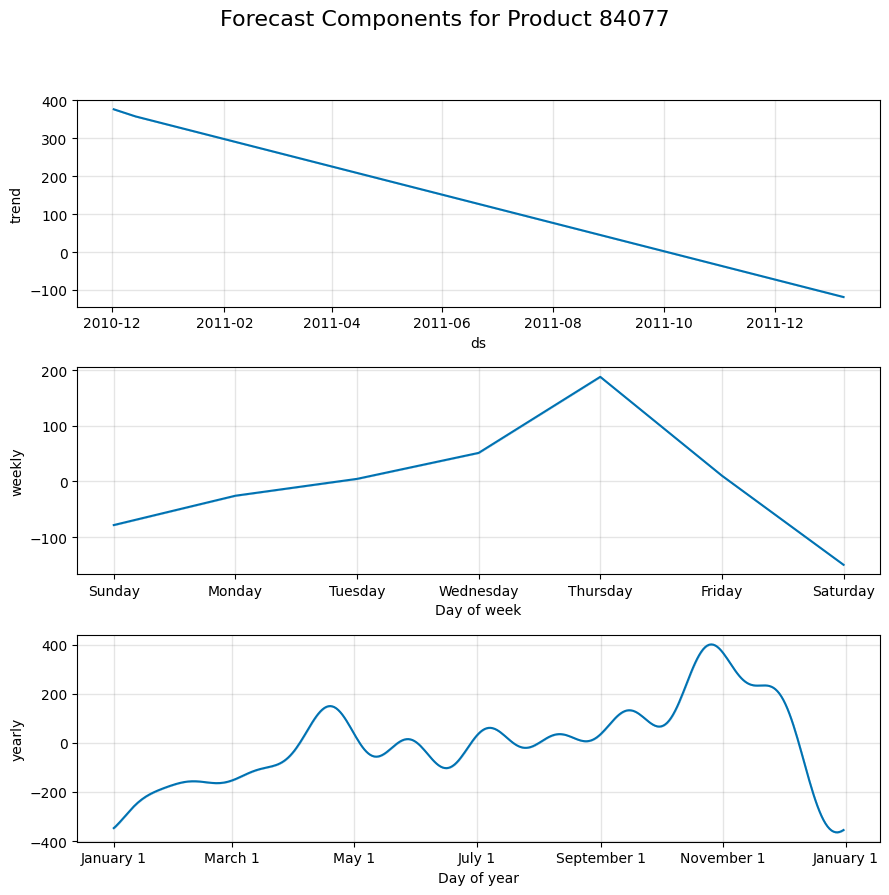


--- Demand Forecasting (Product Level) Complete! ---


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your prepared DataFrame from the initial cleaning steps

print("\n--- Starting Demand Forecasting (Product Level) ---")

# 1. Identify Key Products - REVISED STRATEGY
# Find products that have occurred on at least a minimum number of distinct days
min_sales_days = 30 # A reasonable threshold for basic time series forecasting
frequent_products = df.groupby('StockCode')['InvoiceDate'].nunique()
frequent_products = frequent_products[frequent_products >= min_sales_days].index.tolist()

# Now, from these frequent products, let's pick the top 5 by total quantity, if available
# This gives us frequently sold, high-volume items.
filtered_df = df[df['StockCode'].isin(frequent_products)]
selected_products_by_qty = filtered_df.groupby('StockCode')['Quantity'].sum().nlargest(5).index.tolist()

if not selected_products_by_qty:
    print(f"Warning: No products found with sales on at least {min_sales_days} distinct days. Please reduce 'min_sales_days' or check data.")
    # As a fallback, you might try a lower number or just select any 2 products
    # For now, we'll exit or skip if no suitable products are found.
    exit() # Or handle more gracefully

# For this demonstration, we'll use the top 3 of these suitable products
selected_products = selected_products_by_qty[:3]
print(f"\nSelected products for detailed demand forecasting (based on sales frequency and quantity): {selected_products}")


# --- Loop through each selected product to prepare data and forecast ---
product_forecasts = {} # Dictionary to store forecasts for each product

for product_code in selected_products:
    print(f"\n--- Processing product: {product_code} ---")

    # Filter data for the current product
    product_df = df[df['StockCode'] == product_code].copy()

    # 2. Aggregate Product-Level Quantity (Daily)
    # Extract date part and sum Quantity
    product_daily_qty = product_df.groupby(product_df['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()
    product_daily_qty['InvoiceDate'] = pd.to_datetime(product_daily_qty['InvoiceDate'])
    product_daily_qty.set_index('InvoiceDate', inplace=True)

    # 3. Handle Missing Dates for Products (Resampling)
    # Create a full date range for this product
    full_date_range_product = pd.date_range(start=product_daily_qty.index.min(), end=product_daily_qty.index.max(), freq='D')
    product_daily_qty = product_daily_qty.reindex(full_date_range_product, fill_value=0)

    print(f"Total days in dataset for {product_code} (after resampling): {len(product_daily_qty)}")


    # CRITICAL CHECK: Ensure enough data points for Prophet
    if len(product_daily_qty) < 2: # Prophet needs at least 2 non-NaN data points
        print(f"Skipping product {product_code}: Not enough data points ({len(product_daily_qty)}) for forecasting after resampling. Prophet requires at least 2.")
        continue

    # 4. Apply Prophet Model for Each Product
    prophet_product_df = pd.DataFrame({
        'ds': product_daily_qty.index,
        'y': product_daily_qty['Quantity']
    })

    # Initialize and fit Prophet model for the product
    product_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    product_model.fit(prophet_product_df)
    print(f"Prophet model fitted for product {product_code}.")


    # 5. Generate and Visualize Product-Level Forecasts
    future_product = product_model.make_future_dataframe(periods=30) # Forecast next 30 days
    forecast_product = product_model.predict(future_product)
    product_forecasts[product_code] = forecast_product # Store forecast

    print(f"Forecast Head for {product_code} (future predictions):")
    print(forecast_product[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    # Visualize the forecast for the current product
    fig, ax = plt.subplots(figsize=(18, 8))
    product_model.plot(forecast_product, ax=ax)
    plt.title(f'Daily Quantity Forecast for Product {product_code}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Quantity Sold', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Visualize product forecast components
    product_model.plot_components(forecast_product)
    plt.suptitle(f'Forecast Components for Product {product_code}', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

print("\n--- Demand Forecasting (Product Level) Complete! ---")


--- Starting Price Optimization Analysis ---


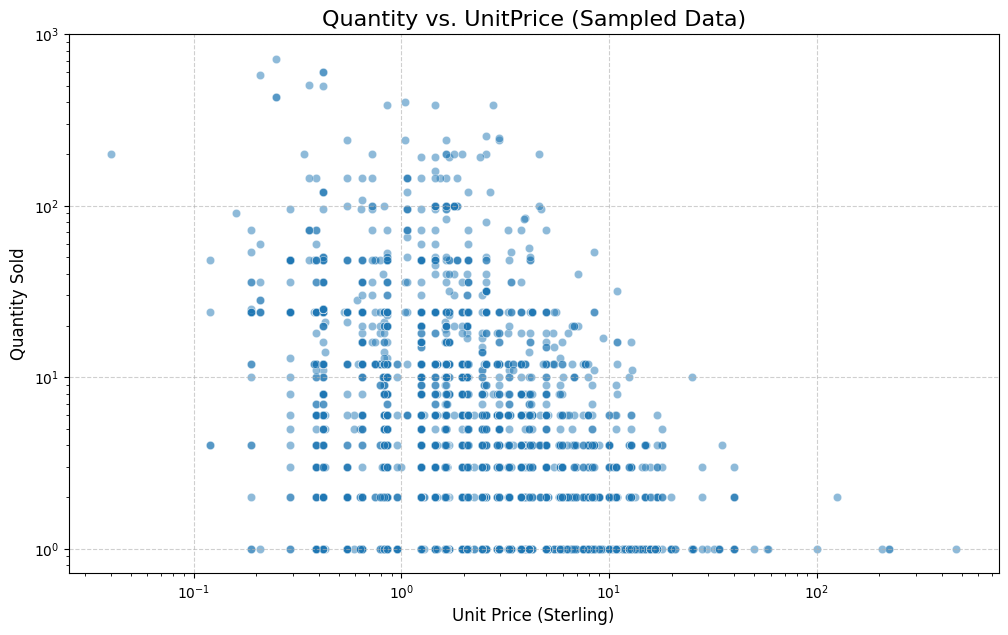


--- Analyzing Price Distribution ---


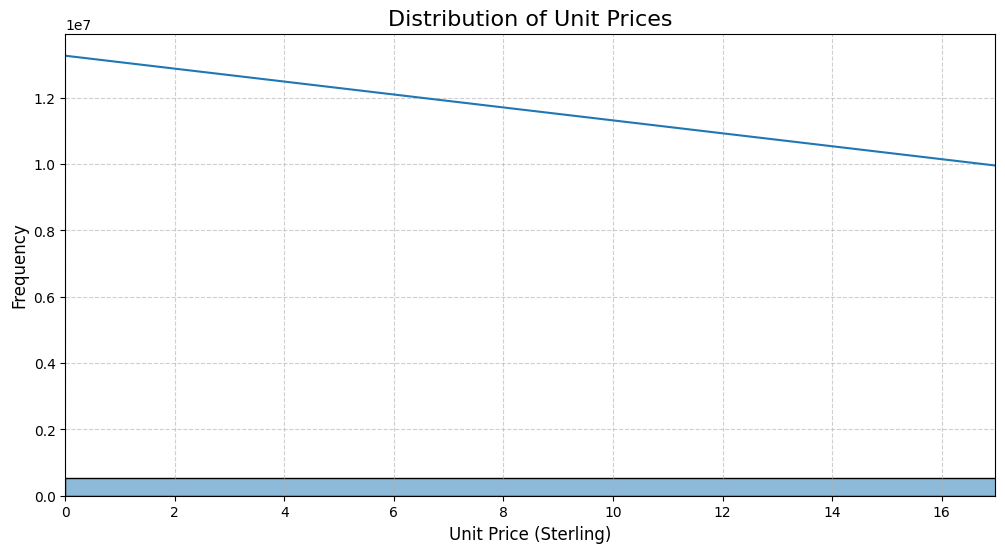

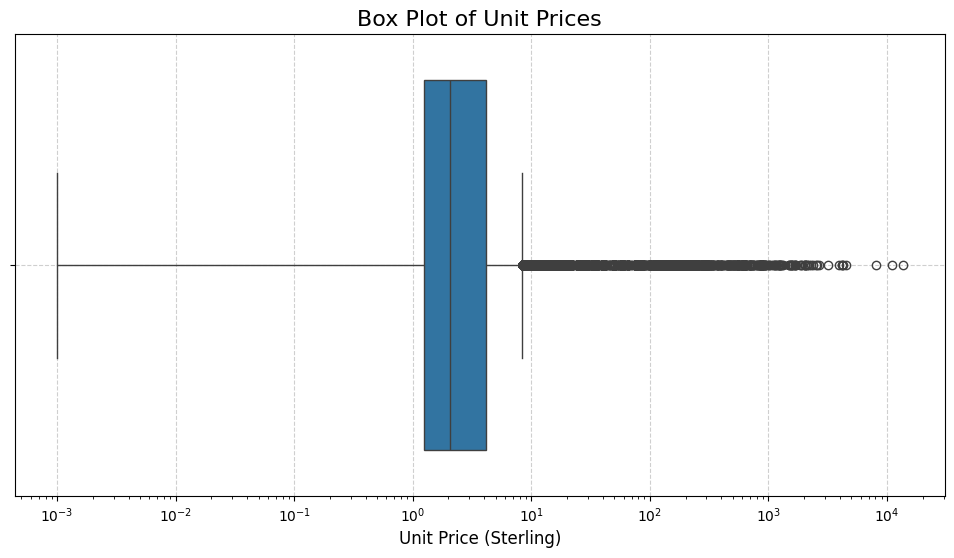


--- Analyzing Price vs. Quantity for selected products: ['23166', '22197', '84077'] ---


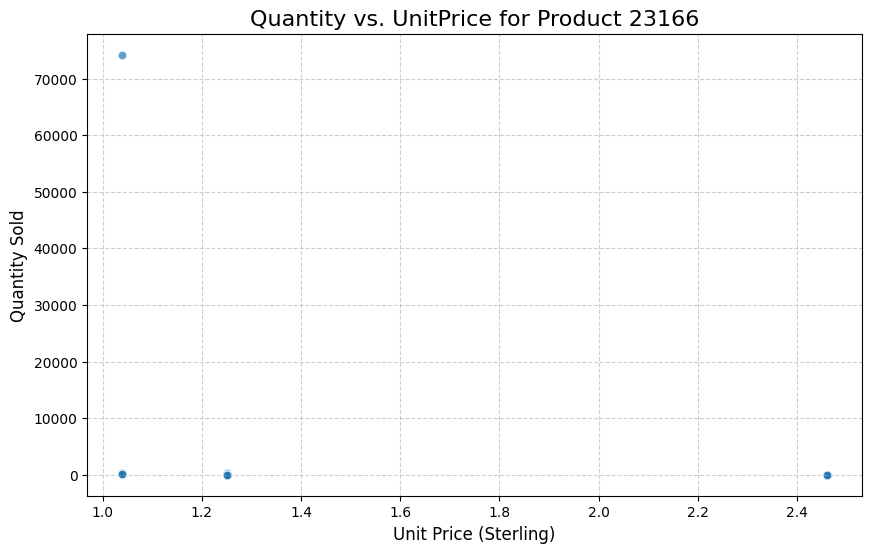


Descriptive Statistics for Product 23166:
        UnitPrice      Quantity
count  250.000000    250.000000
mean     1.468480    312.132000
std      0.501029   4692.895055
min      1.040000      1.000000
25%      1.250000      2.000000
50%      1.250000      8.000000
75%      1.250000     12.000000
max      2.460000  74215.000000


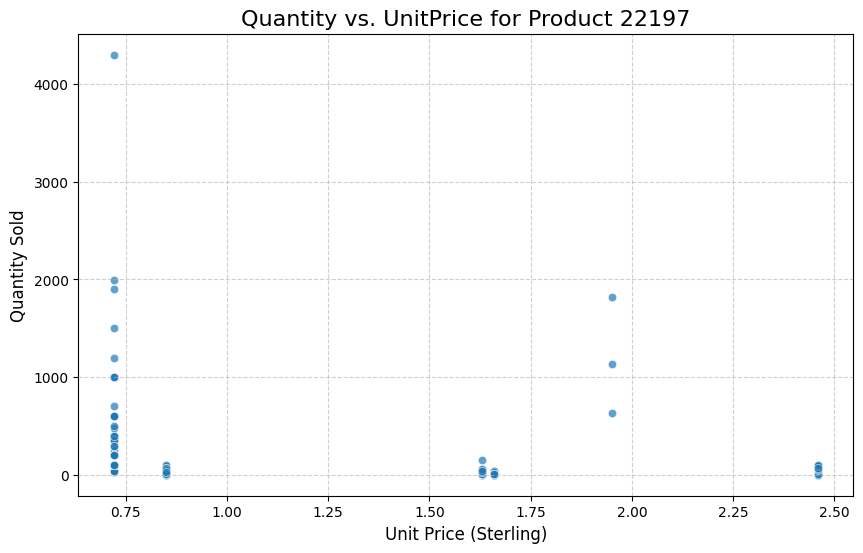


Descriptive Statistics for Product 22197:
         UnitPrice    Quantity
count  1426.000000  1426.00000
mean      1.042468    39.91655
std       0.387269   171.43851
min       0.720000     1.00000
25%       0.850000     4.00000
50%       0.850000    12.00000
75%       0.850000    24.00000
max       2.460000  4300.00000


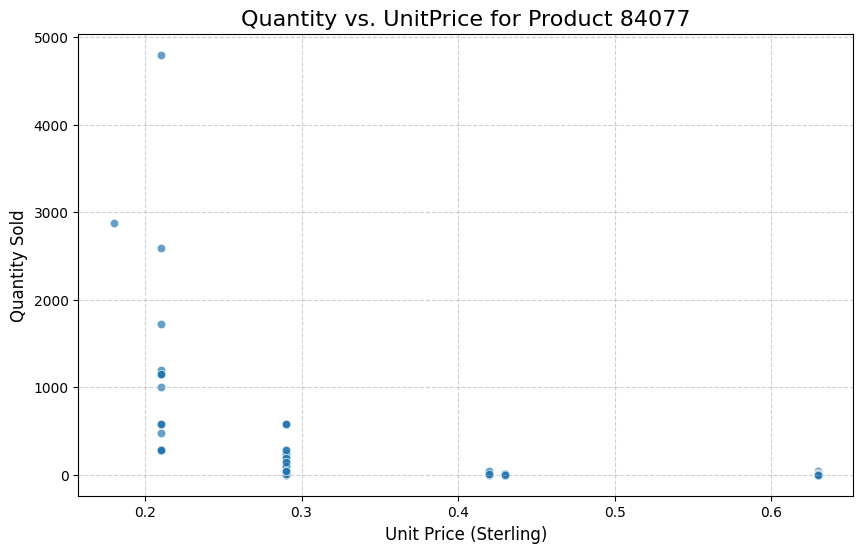


Descriptive Statistics for Product 84077:
        UnitPrice     Quantity
count  537.000000   537.000000
mean     0.320670   102.508380
std      0.102945   305.915241
min      0.180000     1.000000
25%      0.290000    48.000000
50%      0.290000    48.000000
75%      0.290000    48.000000
max      0.630000  4800.000000

--- Price Optimization Analysis Complete! ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For log transformation

# Assuming 'df' is your clean, prepared DataFrame from Phase 1

print("\n--- Starting Price Optimization Analysis ---")

# 1. Visualize Price vs. Quantity for overall data
# It's better to visualize on a subset or with density plots due to data size and overlap
# Let's consider a sample or use bins for a clearer view.
# Also, log transformation can help with skewed data.

plt.figure(figsize=(12, 7))
sns.scatterplot(x='UnitPrice', y='Quantity', data=df.sample(n=5000, random_state=42), alpha=0.5)
plt.title('Quantity vs. UnitPrice (Sampled Data)', fontsize=16)
plt.xlabel('Unit Price (Sterling)', fontsize=12)
plt.ylabel('Quantity Sold', fontsize=12)
plt.xscale('log') # Use log scale for UnitPrice to better visualize wide range
plt.yscale('log') # Use log scale for Quantity to better visualize wide range
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n--- Analyzing Price Distribution ---")
plt.figure(figsize=(12, 6))
sns.histplot(df['UnitPrice'], bins=50, kde=True)
plt.title('Distribution of Unit Prices', fontsize=16)
plt.xlabel('Unit Price (Sterling)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, df['UnitPrice'].quantile(0.99)) # Limit x-axis to 99th percentile for better visualization
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['UnitPrice'])
plt.title('Box Plot of Unit Prices', fontsize=16)
plt.xlabel('Unit Price (Sterling)', fontsize=12)
plt.xscale('log') # Log scale helps with heavily skewed distributions
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# 2. Analyze Price vs. Quantity for a few selected products
# We can use the same `selected_products` from Demand Forecasting if they are relevant for price analysis.
# Let's use the top 3 chosen before: selected_products = ['23166', '22197', '84077']

print(f"\n--- Analyzing Price vs. Quantity for selected products: {selected_products} ---")

for product_code in selected_products:
    product_price_qty_df = df[df['StockCode'] == product_code][['UnitPrice', 'Quantity']].copy()

    if product_price_qty_df.empty:
        print(f"No data for product {product_code}. Skipping price analysis.")
        continue

    # Scatter plot for individual product
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='UnitPrice', y='Quantity', data=product_price_qty_df, alpha=0.7)
    plt.title(f'Quantity vs. UnitPrice for Product {product_code}', fontsize=16)
    plt.xlabel('Unit Price (Sterling)', fontsize=12)
    plt.ylabel('Quantity Sold', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Describe price and quantity for the product
    print(f"\nDescriptive Statistics for Product {product_code}:")
    print(product_price_qty_df.describe())

print("\n--- Price Optimization Analysis Complete! ---")